# General ML pipeline

We would like to have a hierarchical model that can be trained on certain substrates and make predictions on other substrates based on their similarity. In this example I'm trying to generalize the classifier model based on the conversion as target. Afterwards we can work towards a regression model for the e.e.

The classifier pipeline should contain the following steps:

1.   Load & preprocess data
2.   Select representation for ligand
3.   Select representation for substrates
4.   Check similarity of substrates (similarity score and visually via dendrogram)
5.   Split data in train/test (stratified since dataset is small)
6.   Find best model via TPOT
7.   Apply prediction
8.   Evaluate model performance

ToDo: 

*   ~Create ML functions for regression~
*   ~Add scatterplot for evaluation of regression model~
*   Add alternative representations for substrate molecules
*   Check train/test split for each objective
*   Automate feature selection for substrate based on descriptor name
*   Add RandomizedCV for RF model to tune hyperparameters when training ([See this example](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74))
*   Add functions for CM and DL representation of ligands
*   Add option to use standardscaler in ML
*   Add option to use XGB instead of only RF/tpot in ML section
*   Add featurewiz for feature importance analysis


## Prepare packages and paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_to_google_drive_folder = '/content/drive/My Drive/OBeLiX paper'  # your path to the shared folder

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score, accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [ ]:
!pip install tpot
from tpot import TPOTClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Utility functions

In [ ]:
def head(filename: str, n: int):
    try:
        with open(filename) as f:
            head_lines = [next(f).rstrip() for x in range(n)]
    except StopIteration:
        with open(filename) as f:
            head_lines = f.read().splitlines()
    return head_lines


def detect_delimiter(filename: str, n=3):
  # source: https://stackoverflow.com/questions/3952132/how-do-you-dynamically-identify-unknown-delimiters-in-a-data-file
    sample_lines = head(filename, n)
    common_delimiters= [',',';','\t',' ','|',':']
    for d in common_delimiters:
        ref = sample_lines[0].count(d)
        if ref > 0:
            if all([ ref == sample_lines[i].count(d) for i in range(1,n)]):
                return d
    return ','


def load_csv_or_excel_file_to_df(path_to_file):
  if path_to_file.endswith('.xlsx') or path_to_file.endswith('.XLSX'):
    df = pd.read_excel(path_to_file)
  elif path_to_file.endswith('.csv') or path_to_file.endswith('.CSV'):
    df = pd.read_csv(path_to_file, sep=detect_delimiter(path_to_file))
  else:
    raise ValueError(f'{path_to_file} is not a valid csv or excel file')
  
  return df

def merge_dfs(df1, left_index, df2, right_index):
  return df1.merge(df2, left_on=[left_index], right_on=[right_index])

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def plot_dendrogram_for_substrate_rep(df, representation_type):
  # for plotting drop all columns containing smiles
  df = df.loc[:, ~df.columns.str.contains('SMILES|smiles')]
  scaler = StandardScaler()
  X = scaler.fit_transform(df.iloc[:,1:].values)
  model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
  model = model.fit(X)
  plt.figure()
  plt.title(f"Hierarchical Clustering Dendrogram {representation_type}")
  # plot the top n levels of the dendrogram
  try:
    plot_dendrogram(model, labels = df['index'].values, truncate_mode="level", p=5)
  except KeyError:
    # in this case the experimental df is present and the Substrate column is used as label
    plot_dendrogram(model, labels = df['Substrate'].values, truncate_mode="level", p=5)
  plt.xlabel("Number of points in node (or index of point if no parenthesis).")
  plt.show()

### Tests

In [ ]:
delimiter_test = detect_delimiter(f'{path_to_google_drive_folder}/jnj_data/jnjdata_sm12345678_MeOH_16h.csv')
delimiter_test

';'

## Load data & preprocess functions

### Ligand descriptors

In [ ]:
def load_and_fix_indexing_tud_dft_descriptors(clean_tud_dft_descriptors_file_path, left_merge_index, exp_df, right_merge_index, columns_of_representation_to_select=None):
  # general function that loads the TUD generated DFT descriptors and merges them with a second df
  # load cleaned obelix descriptors merged with JnJ data
  tud_df = load_csv_or_excel_file_to_df(clean_tud_dft_descriptors_file_path)

  # Remove some columns
  descriptors_df = tud_df.loc[:,~tud_df.columns.str.contains('index|idx|element')]  # remove elements, indices
  descriptors_df = descriptors_df.loc[:,~descriptors_df.columns.str.contains('orbital_occupation')]  # remove descriptors that are prone to introducing errors
  descriptors_df = descriptors_df.drop(['Code', 'Ligand alias', 	'CAS', 	'Formula',	'Class',	'Eq to Rh', 'Canonical SMILES', 'Isomeric SMILES', 'InChI', 'InChI Key', 'InChI key main layer', 
                                            'filename_tud', 'cas_or_ligand#', 'cas', 'optimization_success_dft'], axis=1)  # remove redundant columns
  descriptors_df = preprocess_tud_dft_descriptors(descriptors_df)
  if columns_of_representation_to_select is not None:
    columns_of_representation_to_select.extend([left_merge_index])  # keep left merge index and all selected descriptors
    descriptors_df = descriptors_df[columns_of_representation_to_select] 
  exp_df = merge_dfs(exp_df, left_merge_index, descriptors_df, right_merge_index)

  return exp_df

def preprocess_tud_dft_descriptors(df):
  
  df["min_NBO_donor"] = df[["nbo_charge_max_donor_dft", "nbo_charge_min_donor_dft"]].min(axis=1)
  df["max_NBO_donor"] = df[["nbo_charge_max_donor_dft", "nbo_charge_min_donor_dft"]].max(axis=1)
  
  df["min_bv_donor"] = df[["buried_volume_donor_min", "buried_volume_donor_max"]].min(axis=1)
  df["max_bv_donor"] = df[["buried_volume_donor_min", "buried_volume_donor_max"]].max(axis=1)
  
  df["Rh_donor_min_d"] = df[["distance_Rh_max_donor_gaussian", "distance_Rh_min_donor_gaussian"]].min(axis=1)
  df["Rh_donor_max_d"] = df[["distance_Rh_min_donor_gaussian", "distance_Rh_max_donor_gaussian"]].max(axis=1)
  
  df['std_quad'] =   df[["NE_quad", "NW_quad", "SW_quad", "SE_quad"]].std(axis=1)
  df['min_quad'] =   df[["NE_quad", "NW_quad", "SW_quad", "SE_quad"]].min(axis=1)
  df['max_quad'] =   df[["NE_quad", "NW_quad", "SW_quad", "SE_quad"]].max(axis=1)
  
  df['std_oct'] = df[['+,+,+_octant','-,+,+_octant', '-,-,+_octant', '+,-,+_octant',	'+,-,-_octant',	'-,-,-_octant',	'-,+,-_octant',	'+,+,-_octant']].std(axis=1)
  df['min_oct'] = df[['+,+,+_octant','-,+,+_octant', '-,-,+_octant', '+,-,+_octant',	'+,-,-_octant',	'-,-,-_octant',	'-,+,-_octant',	'+,+,-_octant']].min(axis=1)
  df['max_oct'] = df[['+,+,+_octant','-,+,+_octant', '-,-,+_octant', '+,-,+_octant',	'+,-,-_octant',	'-,-,-_octant',	'-,+,-_octant',	'+,+,-_octant']].max(axis=1)
  
  df['ratio_std_oct_std_quad'] = df['std_oct']/df['std_quad']
  df['ratio_min_oct_min_quad'] = df['min_oct']/df['min_quad']


  df["lone_pair_occ_min"] = df[["lone_pair_occupancy_max_donor_dft", "lone_pair_occupancy_min_donor_dft"]].min(axis=1)
  df["lone_pair_occ_max"] = df[["lone_pair_occupancy_max_donor_dft", "lone_pair_occupancy_min_donor_dft"]].max(axis=1)
  
  df["bite_angle_sin"] = np.sin(df.bite_angle)
  df["bite_angle_cos"] = np.cos(df.bite_angle)
  
  df["cone_angle_sin"] = np.sin(df.cone_angle)
  df["cone_angle_cos"] = np.cos(df.cone_angle)

  return df


### Substrate descriptors

In [ ]:
def load_substrate_representation(path_to_csv_file, df_to_merge_on, left_merge_index, right_merge_index, rename_columns_dict=None, columns_of_representation_to_select=None):
  # load representation of substrate from file 
  substrate_df = load_csv_or_excel_file_to_df(path_to_csv_file)
  # rename columns in loaded file if needed
  if rename_columns_dict is not None:
    substrate_df = substrate_df.rename(columns=rename_columns_dict)
  if columns_of_representation_to_select is not None:
    columns_of_representation_to_select.extend([right_merge_index])  # keep right merge index (index of substrate file) and all selected descriptors
    substrate_df = substrate_df[columns_of_representation_to_select] 
  df_to_merge_on = merge_dfs(df_to_merge_on, left_merge_index, substrate_df, right_merge_index)
  # df_to_merge_on = df_to_merge_on.loc[:,~df_to_merge_on.columns.str.contains('index')]  # drop the index columns
  return df_to_merge_on

## Select representation for ligands

In [ ]:
def load_and_merge_selected_ligand_representation(representation_type, df_to_merge_on, right_merge_index, columns_of_representation_to_select=None):
  available_ligand_representation_types = ['tud_nbd_dft', 'DL', 'CM']
  if not representation_type in available_ligand_representation_types:
    raise KeyError(f'Representation type {representation_type} not in available ligand representations')

  # merge TUD DFT descriptors
  if representation_type == available_ligand_representation_types[0]:
    path_to_tud_descriptors = f'{path_to_google_drive_folder}/clean_Rh_ligand_NBD_DFT_descriptors_v3.xlsx'
    left_merge_index = 'Ligand#'
    ligand_df = load_and_fix_indexing_tud_dft_descriptors(path_to_tud_descriptors, left_merge_index, df_to_merge_on, right_merge_index, columns_of_representation_to_select)

    return ligand_df

  # merge DL descriptors

  # merge QML generated CM vectors

## Select representation for substrates

In [ ]:
def load_and_merge_selected_substrate_representation(representation_type, left_merge_index, df_to_merge_on, right_merge_index, columns_of_representation_to_select=None):
  available_substrate_representation_types = ['DL','fps','rdkit','sterimol']
  if not representation_type in available_substrate_representation_types:
    raise KeyError(f'Representation type {representation_type} not in available substrate representations')

  path_to_substrate_descriptor = f"{path_to_google_drive_folder}/substrates/substrate_{representation_type}.csv"
  rename_columns_dict = {'SMILES': 'substrate_smiles'}

  exp_df_with_ligand_and_substrate = load_substrate_representation(path_to_substrate_descriptor, df_to_merge_on, left_merge_index, right_merge_index, rename_columns_dict, columns_of_representation_to_select)
  return exp_df_with_ligand_and_substrate

## ML

In [ ]:
def split_and_train(split_object, ml_model, train_data, substrate_names_column, target):
  split = split_object

  for train_index, val_index in split.split(train_data, train_data[substrate_names_column]):
      train_data_split = train_data.iloc[train_index]
      val_data_split = train_data.iloc[val_index]
  features_data = train_data_split.drop([substrate_names_column, target], axis=1)
  target_data = train_data_split[target]

  trained_model = ml_model.fit(features_data, target_data)

  return trained_model

def prepare_binary_classification_data(df, target, target_threshold):
  # for classification, transform the data based on 
  df.loc[df[target] < target_threshold, target] = 0
  df.loc[df[target] > target_threshold, target] = 1
  df[target] = df[target].astype(np.int64)

  return df


def train_and_validate_classifier(train_data, target, target_threshold, list_of_substrates, test_size, ml_model, substrate_names_column):
  # conversion of target property based on threshold should be done outside of this function already
  # Create Stratified Shuffle Split object
  print('Training classifier')
  split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  trained_model = split_and_train(split, ml_model, train_data, substrate_names_column, target)
  return trained_model

def predict_and_evaluate_performance(test_data, trained_model, list_of_substrates, substrate_names_column, target):
  # for prediction on unseen substrate
  print('Testing classifier')
  prediction_features = test_data.drop([substrate_names_column, target], axis=1)
  predictions = trained_model.predict(prediction_features)
  y_true, y_pred = test_data[target].astype(int), predictions
  # Assess the accuracy of predictions
  accuracy = accuracy_score(y_true, y_pred)
  balanced_accuracy = balanced_accuracy_score(y_true, y_pred)  # takes imbalanced dataset into account
  print("Balanced accuracy", balanced_accuracy)  
  print("Accuracy:", accuracy)
  score = r2_score(y_true, y_pred)
  print('R2 score:', score)
  confusion_mat = confusion_matrix(y_true, y_pred)
  print('Confusion matrix', confusion_mat)

def train_and_validate_regressor(train_data, target, list_of_substrates, test_size, ml_model, substrate_names_column):
  # Create Stratified Shuffle Split object
  print('Training regressor')
  split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  trained_model = split_and_train(split, ml_model, train_data, substrate_names_column, target)
  return trained_model

def predict_and_evaluate_performance_regressor(test_data, trained_model, list_of_substrates, substrate_names_column, target, title=None, ax=None):
  print('Testing regressor')
  predictions = trained_model.predict(test_data.drop([substrate_names_column, target], axis=1))
  y_true, y_pred = test_data[target], predictions
  score = r2_score(y_true, y_pred)
  print('R2 score:', score)
  print('Plotting results')
  if ax is None:
    fig, ax = plt.subplots()
  sns.regplot(x=y_true, y=y_pred, ax=ax)
  ax.set_xlabel('True')
  ax.set_ylabel('Predicted')
  ax.set_title(title)
  ax.text(0.05, 0.9, f'$R^2$={r2_score(y_true, y_pred):.2f}', transform=ax.transAxes)
  fig.show()


def show_feature_importance(df, trained_model, target, substrate_names_column):
  df = df.drop([substrate_names_column, target], axis=1)
  # I assume that we only use RF or TPOT for now
  try:  # in the case of RF there is a property that contains feature importances
    importances = trained_model.feature_importances_
  except AttributeError:
    importances = trained_model.fitted_pipeline_.steps[-1][1].feature_importances_
  std = np.std([tree.feature_importances_ for tree in trained_model.estimators_], axis=0)
  forest_importances = pd.Series(importances, index=df.columns.values)

  fig = px.bar(forest_importances).update_traces(
      error_y={
          "type": "data",
          "symmetric": False,
          "array": std,
      }
  )
  fig.update_layout(    font=dict(
          size=12,
          color="black"), 
          xaxis_title='Feature')
  # px.plot.bar(yerr=std, ax=ax)
  # ax.set_title("Feature importances Random Forest Regressor")
  # fig.tight_layout()
  fig.update_layout(showlegend=False)
  # fig.write_image(f"{path_to_google_drive_folder}/machine_learning/feature_importance_RF.png", scale = 5)

  fig.show()
  # positions = range(trained_model.feature_importances_.shape[0])
  # plt.bar(positions, trained_model.feature_importances_)
  # plt.show()

## Application of full pipeline

Example use case of the pipeline without any generalization. Run this to define all variables for the rest of the objectives.

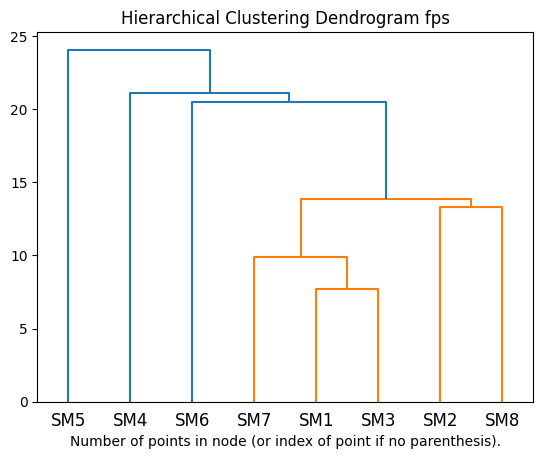

Training classifier
Testing classifier
Balanced accuracy 0.7759979977474659
Accuracy: 0.84375
R2 score: 0.2791890877236891
Confusion matrix [[ 36  25]
 [  5 126]]


Training regressor
Testing regressor
R2 score: 0.4534751541291715
Plotting results


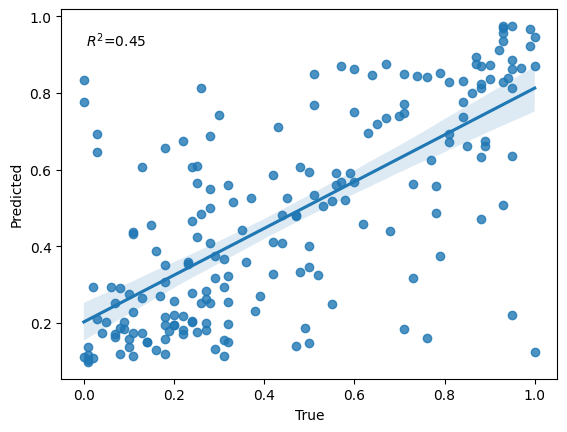

In [ ]:
# representation selection and data loading with example ML approach afterwards
# --Ligand

# select descriptors for ligand representation to keep
features_simple = ['bite_angle', 'cone_angle', 'buried_volume_Rh_4A', 'buried_volume_Rh_5A',
                   'nbo_charge_Rh_dft',  'buried_volume_Rh_6A', 'buried_volume_Rh_7A', 'dispersion_p_int_Rh_gfn2_xtb', 'dipole_moment_dft',
                   'dispersion_energy_dft','mulliken_charge_Rh_dft', 'homo_energy_dft', 'lumo_energy_dft' , 'buried_volume_Rh_3.5A', 'dipole_gfn2_xtb', 
                   'ea_gfn2_xtb', 'min_NBO_donor', 'max_NBO_donor', 'min_bv_donor', 'max_bv_donor', 'Rh_donor_min_d', 'Rh_donor_max_d', 
                   'std_quad', 'min_quad', 'max_quad', 'std_oct', 'max_oct', 'min_oct', 'lone_pair_occ_max', 'lone_pair_occ_min', 'bite_angle_sin', 'bite_angle_cos',
                   'cone_angle_sin', 'cone_angle_cos', 'ratio_std_oct_std_quad', 'ratio_min_oct_min_quad'] 

# automated merging of ligand representations
selected_ligand_representations = ['tud_nbd_dft']
# merge first selected representation with experimental JnJ data
exp_df = load_csv_or_excel_file_to_df(f'{path_to_google_drive_folder}/jnj_data/jnjdata_sm12378_MeOH_16h.csv')
right_merge_index = 'Ligand#'  # I assume that all data is merged based on Ligand#
first_rep_and_exp_df = load_and_merge_selected_ligand_representation(selected_ligand_representations[0], exp_df, right_merge_index, features_simple)
ligand_df = first_rep_and_exp_df
if len(selected_ligand_representations) > 1:
  for selected_ligand_representation in selected_ligand_representations[1:]:
    ligand_df = load_and_merge_selected_ligand_representation(selected_ligand_representation, ligand_df, right_merge_index)

# --substrate

# select descriptors for substrate representation to keep
fps_df = load_csv_or_excel_file_to_df(f"{path_to_google_drive_folder}/substrates/substrate_fps.csv")
fps_columns = [col for col in fps_df.columns if  col.isnumeric()]
sterimol_columns = ['L', 'B_1', 'B_5']

# automated merging of representations
selected_substrate_representations = ['fps']
# merge first selected representation with representation for ligands and experimental JnJ data
df_to_merge_on = ligand_df
left_merge_index = 'Substrate'
right_merge_index = 'index'
# merge substrate representation, ligand representation and experimental data
first_rep_and_ligand_df = load_and_merge_selected_substrate_representation(selected_substrate_representations[0], left_merge_index, df_to_merge_on, right_merge_index, fps_columns)
first_rep_and_ligand_df = first_rep_and_ligand_df.drop(columns=['index'])  # drop substrate's index column which is the same as Substrate column
# but also load only substrate descriptors for similarity check
first_substrate_df = load_csv_or_excel_file_to_df(f"{path_to_google_drive_folder}/substrates/substrate_{selected_substrate_representations[0]}.csv")
# check similarity of substrates based on first selected representation
plot_dendrogram_for_substrate_rep(first_substrate_df, selected_substrate_representations[0])

# do this again if multiple representations are chosen
final_df = first_rep_and_ligand_df
substrate_df = first_substrate_df
if len(selected_substrate_representations) > 1:
  for selected_substrate_representation in selected_substrate_representations[1:]:
    # merge substrate descriptors with ligand descriptors and experimental data
    final_df = load_and_merge_selected_substrate_representation(selected_substrate_representation, left_merge_index, final_df, right_merge_index, sterimol_columns)
    final_df = final_df.drop(columns=['index'])  # drop substrate's index column which is the same as Substrate column
    # check dendrogram for other representations as well
    next_substrate_df = load_csv_or_excel_file_to_df(f"{path_to_google_drive_folder}/substrates/substrate_{selected_substrate_representation}.csv")
    plot_dendrogram_for_substrate_rep(next_substrate_df, selected_substrate_representation)
    left_merge_index = 'index'
    # merge only substrate descriptors such that a dendrogram of combination can be created
    substrate_df = load_and_merge_selected_substrate_representation(selected_substrate_representation, left_merge_index, next_substrate_df, 'index')
    
# if multiple reps chosen, make a similarity dendrogram based on combination of representations
if len(selected_substrate_representations) > 1:
  combination_of_rep_types = " + ".join(selected_substrate_representations)
  plot_dendrogram_for_substrate_rep(substrate_df, combination_of_rep_types)

# final filtering
final_df = final_df.dropna()

# --ML
# define variables that we will use for this objective
# classification
target_classification = 'Conversion'
target_threshold = 0.8
list_of_training_substrates = ['SM1', 'SM2']
test_size = 0.2
substrate_names_column = 'Substrate'
features_classification = features_simple + fps_columns + [target_classification] + [substrate_names_column]
# somehow the 'index' column is also added to this list, filter for it
features_classification = list(filter(lambda x: x!='index', features_classification))
features_classification = list(filter(lambda x: x!='Ligand#', features_classification))
classification_df = final_df.copy()
classification_df = classification_df[features_classification]
classification_df = prepare_binary_classification_data(classification_df, target_classification, target_threshold)
model_classifier = RandomForestClassifier(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=13, n_estimators=100, random_state=42)

train_data_classification = classification_df[classification_df[substrate_names_column].isin(list_of_training_substrates)]
train_data_classification[target_classification]
trained_model_classifier = train_and_validate_classifier(train_data_classification, target_classification, target_threshold, list_of_training_substrates, test_size, model_classifier, substrate_names_column)

list_of_test_substrates = ['SM3']
test_data_classification = classification_df[classification_df[substrate_names_column].isin(list_of_test_substrates)]
predict_and_evaluate_performance(test_data_classification, trained_model_classifier, list_of_test_substrates, substrate_names_column, target_classification)
show_feature_importance(test_data_classification, trained_model_classifier, target_classification, substrate_names_column)

# regression
target_regression = 'EE'
list_of_training_substrates = ['SM1', 'SM2']
test_size = 0.2
substrate_names_column = 'Substrate'
features_regression = features_simple + fps_columns + [target_regression] + [substrate_names_column]
# somehow the 'index' column is also added to this list, filter for it
features_regression = list(filter(lambda x: x!='index', features_regression))
features_regression = list(filter(lambda x: x!='Ligand#', features_regression))
regression_df = final_df[features_regression]
model_regressor = RandomForestRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=13, n_estimators=100, random_state=42)

# train model
train_data_regression = regression_df[regression_df[substrate_names_column].isin(list_of_training_substrates)]
trained_model_regressor = train_and_validate_regressor(train_data_regression, target_regression, list_of_training_substrates, test_size, model_regressor, substrate_names_column)

list_of_test_substrates = ['SM3']
test_data_regression = regression_df[regression_df[substrate_names_column].isin(list_of_test_substrates)]
predict_and_evaluate_performance_regressor(test_data_regression, trained_model_regressor, list_of_test_substrates, substrate_names_column, target_regression, title=None, ax=None)
show_feature_importance(test_data_regression, trained_model_regressor, target_regression, substrate_names_column)

### Objective 1: Predictions on unseen substrate 

For a complete new substrate, the model gives the performance of 192 ligands with an accuracy as high as possible  
1A Methodology:  
Classification on activity, regression on ee  

*   Use more accurate representation of substrate!!
*   Train on SM1, SM2 (SM7, SM8), predict SM3
*   Train on SM2, SM3 (SM7, SM8), predict SM1
*   Train on SM1, SM3 (SM7, SM8), predict SM2

Define general function:  

In [ ]:
# generalize the approach for objective 1 such that we only have to vary the substrates we use 

def classification_and_regression(list_of_training_substrates, list_of_test_substrates):
  train_data_classification = classification_df[classification_df[substrate_names_column].isin(list_of_training_substrates)]
  trained_model_classifier = train_and_validate_classifier(train_data_classification, target_classification, target_threshold, list_of_training_substrates, test_size, model_classifier, substrate_names_column)
  test_data_classification = classification_df[classification_df[substrate_names_column].isin(list_of_test_substrates)]
  predict_and_evaluate_performance(test_data_classification, trained_model_classifier, list_of_test_substrates, substrate_names_column, target_classification)
  show_feature_importance(test_data_classification, trained_model_classifier, target_classification, substrate_names_column)

  train_data_regression = regression_df[regression_df[substrate_names_column].isin(list_of_training_substrates)]
  trained_model_regressor = train_and_validate_regressor(train_data_regression, target_regression, list_of_training_substrates, test_size, model_regressor, substrate_names_column)
  test_data_regression = regression_df[regression_df[substrate_names_column].isin(list_of_test_substrates)]
  predict_and_evaluate_performance_regressor(test_data_regression, trained_model_regressor, list_of_test_substrates, substrate_names_column, target_regression, title=None, ax=None)
  show_feature_importance(test_data_regression, trained_model_regressor, target_regression, substrate_names_column)

Train on SM1, SM2 (SM7, SM8), predict SM3 (should give the exact same results as above example if pipeline works correctly)

Training classifier
Testing classifier
Balanced accuracy 0.8055312226254536
Accuracy: 0.8541666666666666
R2 score: 0.3272431485421098
Confusion matrix [[ 41  20]
 [  8 123]]


Training regressor
Testing regressor
R2 score: 0.358847794860097
Plotting results


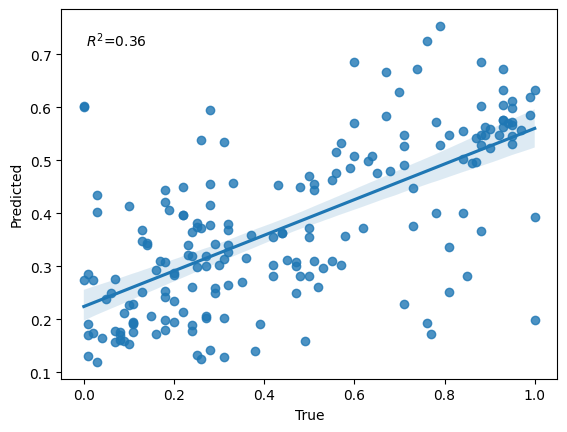

In [ ]:
list_of_training_substrates = ['SM1', 'SM4', 'SM7']
list_of_test_substrates = ['SM3']
classification_and_regression(list_of_training_substrates, list_of_test_substrates)

Training classifier
Testing classifier
Balanced accuracy 0.7782967032967033
Accuracy: 0.8177083333333334
R2 score: 0.0769230769230771
Confusion matrix [[ 36  16]
 [ 19 121]]


Training regressor
Testing regressor
R2 score: 0.41157627681121667
Plotting results


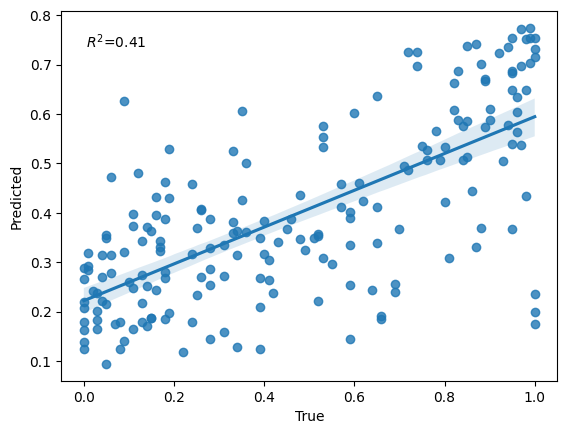

In [ ]:
list_of_training_substrates = ['SM7','SM3','SM8']
list_of_test_substrates = ['SM1']
classification_and_regression(list_of_training_substrates, list_of_test_substrates)

Train on SM2, SM3 (SM7, SM8), predict SM1


Training classifier
Testing classifier
Balanced accuracy 0.8656593406593407
Accuracy: 0.9010416666666666
R2 score: 0.498901098901099
Confusion matrix [[ 41  11]
 [  8 132]]


Training regressor
Testing regressor
R2 score: 0.57549841846162
Plotting results


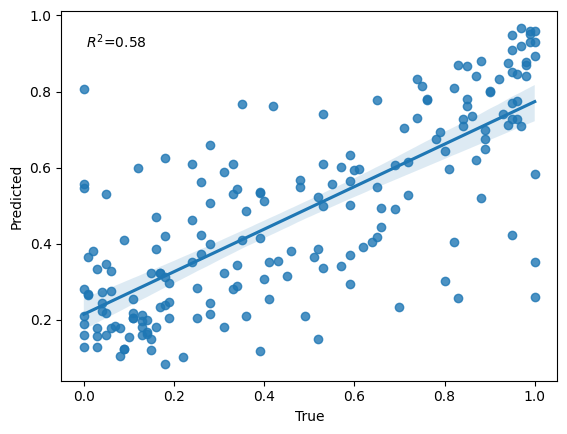

In [ ]:
list_of_training_substrates = ['SM2', 'SM3']
list_of_test_substrates = ['SM1']

classification_and_regression(list_of_training_substrates, list_of_test_substrates)

Training classifier
Testing classifier
Balanced accuracy 0.625
Accuracy: 0.625
R2 score: -0.5
Confusion matrix [[36 60]
 [12 84]]


Training regressor
Testing regressor
R2 score: -0.5342091245617404
Plotting results


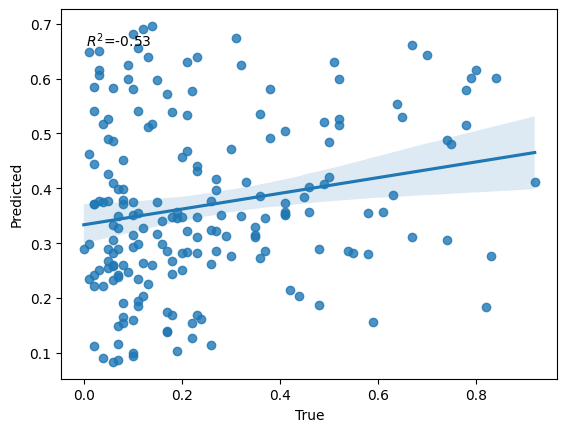

In [ ]:
list_of_training_substrates = ['SM2', 'SM3','SM8']
list_of_test_substrates = ['SM7']

classification_and_regression(list_of_training_substrates, list_of_test_substrates)

Train on SM1, SM3 (SM7, SM8), predict SM2

Training classifier
Testing classifier
Balanced accuracy 0.6161387631975868
Accuracy: 0.6927083333333334
R2 score: -0.8984414278531925
Confusion matrix [[ 19  20]
 [ 39 114]]


Training regressor
Testing regressor
R2 score: -0.6757925382653052
Plotting results


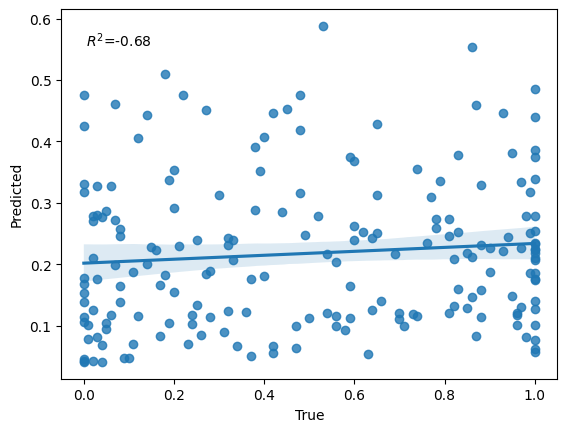

In [ ]:
list_of_training_substrates = ['SM8', 'SM4']
list_of_test_substrates = ['SM2']

classification_and_regression(list_of_training_substrates, list_of_test_substrates)

Training classifier
Testing classifier
Balanced accuracy 0.7742584213172448
Accuracy: 0.8229166666666666
R2 score: -0.09401709401709413
Confusion matrix [[ 27  12]
 [ 22 131]]


Training regressor
Testing regressor
R2 score: 0.022108782284909756
Plotting results


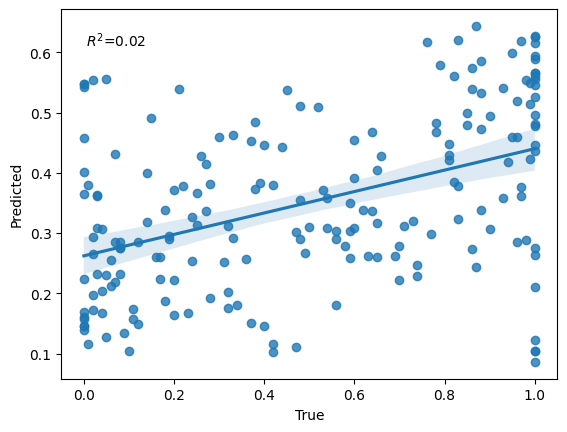

In [ ]:
list_of_training_substrates = ['SM1','SM8']
list_of_test_substrates = ['SM2']

classification_and_regression(list_of_training_substrates, list_of_test_substrates)

### Objective 2: With a few data (as little as possible, max 96, i.e. half of the data) obtained for a complete new substrate, the model gives us the performance or a ranking of the remaining ligands

Methodology:
Classification on activity, regression on ee  
Train on SM3, SM8 and a subset of SM7 (from 12 random data points up to 154 datapoints (80%)) --> Predict the rest of the ligands for SM7



Subset substrate is SM7 and subset size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.716931216931217
Accuracy: 0.7083333333333334
R2 score: -0.18518518518518512
Confusion matrix [[33  9]
 [19 35]]


Training regressor
Testing regressor
R2 score: 0.0721265618480067
Plotting results


Subset substrate is SM7 and subset size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.725718194254446
Accuracy: 0.7142857142857143
R2 score: -0.15868673050615612
Confusion matrix [[28  6]
 [16 27]]


Training regressor
Testing regressor
R2 score: 0.08595325961238331
Plotting results


Subset substrate is SM7 and subset size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7437275985663083
Accuracy: 0.7413793103448276
R2 score: -0.03942652329749108
Confusion matrix [[21  6]
 [ 9 22]]


Training regressor
Testing regressor
R2 score: 0.00183635222694567
Plotting results


Subset substrate is SM7 and subset size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.7947368421052632
Accuracy: 0.7948717948717948
R2 score: 0.17894736842105274
Confusion matrix [[15  4]
 [ 4 16]]


Training regressor
Testing regressor
R2 score: -0.04382539686046005
Plotting results


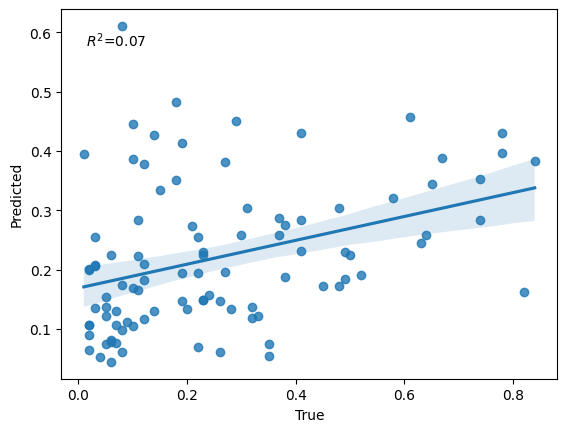

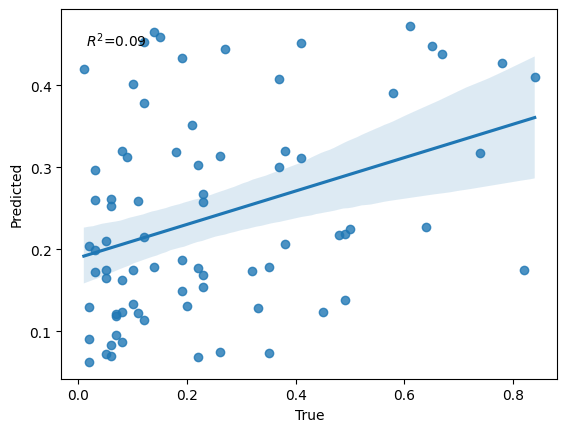

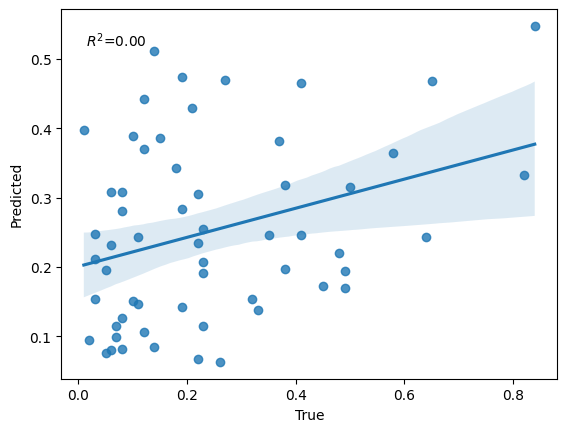

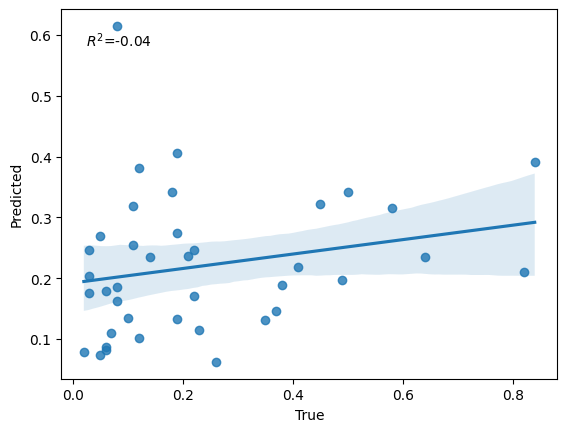

In [ ]:
# generalizing the approach for objective 2 such that we only have to vary the substrates and subset size

def classification_and_regression(list_of_training_substrates, subset_size, subset_substrate):
  print(f'Subset substrate is {subset_substrate} and subset size is {subset_size}')
  # create a subset of SM7 data for training
  subset_data = classification_df.loc[classification_df[substrate_names_column] == subset_substrate]
  subset_train, subset_test = train_test_split(subset_data, test_size=1-subset_size, random_state=42)

  # combine training data from SM3, SM8, and SM7
  training_data_classification = pd.concat([classification_df.loc[classification_df[substrate_names_column] == s] for s in list_of_training_substrates] + [subset_train])

  trained_model_classifier = train_and_validate_classifier(training_data_classification, target_classification, target_threshold, list_of_training_substrates, test_size, model_classifier, substrate_names_column)
  predict_and_evaluate_performance(subset_test, trained_model_classifier, list_of_test_substrates, substrate_names_column, target_classification)
  show_feature_importance(subset_test, trained_model_classifier, target_classification, substrate_names_column)


  # create a subset of SM7 data for training
  subset_data = regression_df.loc[regression_df[substrate_names_column] == subset_substrate]
  subset_train, subset_test = train_test_split(subset_data, test_size=1-subset_size, random_state=42)

  # combine training data from SM3, SM8, and SM7
  training_data_regression = pd.concat([regression_df.loc[regression_df[substrate_names_column] == s] for s in list_of_training_substrates] + [subset_train])
  trained_model_regressor = train_and_validate_regressor(training_data_regression, target_regression, list_of_training_substrates, test_size, model_regressor, substrate_names_column)
  predict_and_evaluate_performance_regressor(subset_test, trained_model_regressor, list_of_test_substrates, substrate_names_column, target_regression, title=None, ax=None)
  show_feature_importance(subset_test, trained_model_regressor, target_regression, substrate_names_column)

# list_of_training_substrates = ['SM3', 'SM8', 'SM7']
# subset_size = 0.7  # use % of subset_substrate for training and the rest to test the model
# subset_substrate = 'SM7'
# classification_and_regression(list_of_training_substrates, subset_size, subset_substrate)
for subset_size in np.arange(0.5, 0.9, 0.1):  # go from subset size of 0.5 to 0.9 with increments
  list_of_training_substrates = ['SM2', 'SM8']
  subset_substrate = 'SM7'  # the subset_size of this substrate is used for training and 1-subset_size of this substrate is used for test  
  classification_and_regression(list_of_training_substrates, subset_size, subset_substrate)

Subset substrate is SM7 and subset size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.7817460317460317
Accuracy: 0.78125
R2 score: 0.11111111111111116
Confusion matrix [[33  9]
 [12 42]]


Training regressor
Testing regressor
R2 score: 0.06125713083879358
Plotting results


Subset substrate is SM7 and subset size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.725718194254446
Accuracy: 0.7142857142857143
R2 score: -0.15868673050615612
Confusion matrix [[28  6]
 [16 27]]


Training regressor
Testing regressor
R2 score: 0.0706937973986318
Plotting results


Subset substrate is SM7 and subset size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7066905615292712
Accuracy: 0.7068965517241379
R2 score: -0.17801672640382327
Confusion matrix [[19  8]
 [ 9 22]]


Training regressor
Testing regressor
R2 score: 0.049716149700643086
Plotting results


Subset substrate is SM7 and subset size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.7960526315789473
Accuracy: 0.7948717948717948
R2 score: 0.17894736842105274
Confusion matrix [[16  3]
 [ 5 15]]


Training regressor
Testing regressor
R2 score: -0.032561318197647404
Plotting results


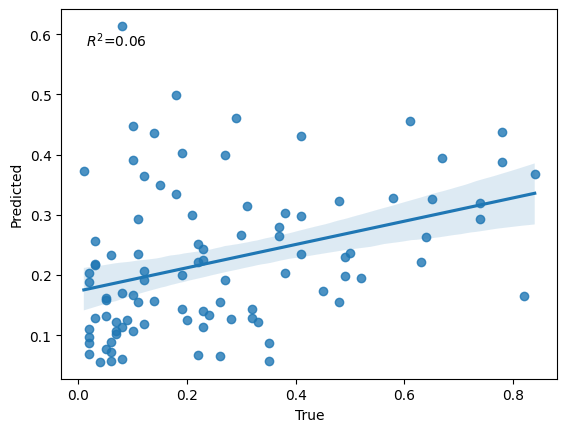

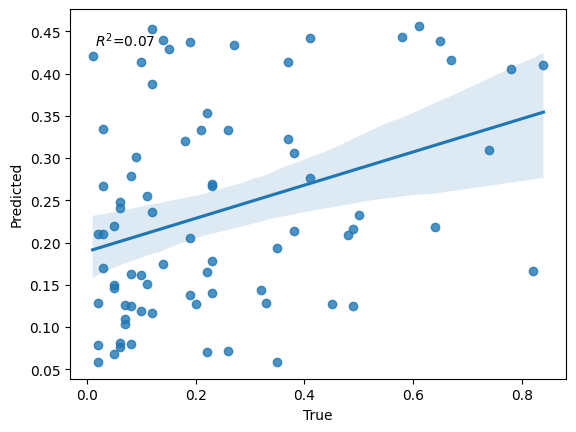

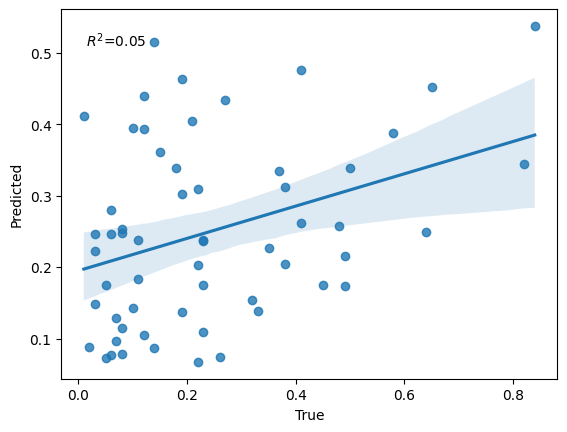

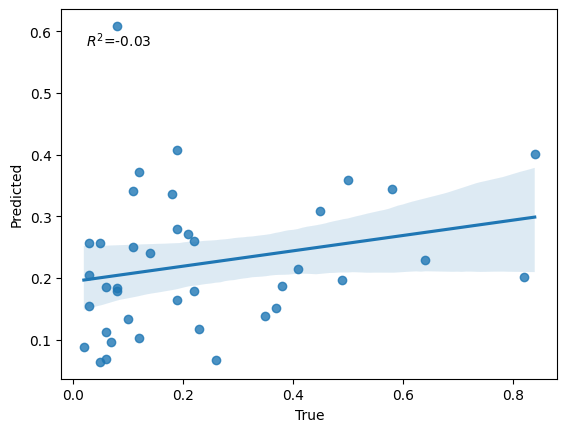

In [ ]:
for subset_size in np.arange(0.5, 0.9, 0.1):  # go from subset size of 0.5 to 0.9 with increments
  list_of_training_substrates = ['SM1', 'SM8']
  subset_substrate = 'SM7'  # the subset_size of this substrate is used for training and 1-subset_size of this substrate is used for test  
  classification_and_regression(list_of_training_substrates, subset_size, subset_substrate)

### Objective 3:
Train SM1 alone, predict SM1, get a nice regression curve with a limited set of descriptors on which we can make comments
Same for SM2, SM3, SM7, SM8

Selected substrate is SM1 and training size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.8676190476190476
Accuracy: 0.9270833333333334
R2 score: 0.5733333333333333
Confusion matrix [[16  5]
 [ 2 73]]


Training regressor
Testing regressor
R2 score: 0.23661161473985115
Plotting results


Selected substrate is SM1 and training size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.807909604519774
Accuracy: 0.8831168831168831
R2 score: 0.34745762711864436
Confusion matrix [[12  6]
 [ 3 56]]


Training regressor
Testing regressor
R2 score: 0.06366245875001009
Plotting results


Selected substrate is SM1 and training size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7767441860465116
Accuracy: 0.8620689655172413
R2 score: 0.2806201550387596
Confusion matrix [[ 9  6]
 [ 2 41]]


Training regressor
Testing regressor
R2 score: 0.1502429728243313
Plotting results


Selected substrate is SM1 and training size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.8482758620689655
Accuracy: 0.8717948717948718
R2 score: 0.3275862068965517
Confusion matrix [[ 8  2]
 [ 3 26]]


Training regressor
Testing regressor
R2 score: 0.4256935981929152
Plotting results


Selected substrate is SM2 and training size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.8501742160278746
Accuracy: 0.8958333333333334
R2 score: 0.1637630662020908
Confusion matrix [[11  3]
 [ 7 75]]


Training regressor
Testing regressor
R2 score: 0.17462219153770875
Plotting results


Selected substrate is SM2 and training size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.7764423076923077
Accuracy: 0.8831168831168831
R2 score: 0.1670673076923076
Confusion matrix [[ 8  5]
 [ 4 60]]


Training regressor
Testing regressor
R2 score: 0.19925959577850205
Plotting results


Selected substrate is SM2 and training size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7620889748549322
Accuracy: 0.896551724137931
R2 score: 0.3268858800773694
Confusion matrix [[ 6  5]
 [ 1 46]]


Training regressor
Testing regressor
R2 score: 0.304844496806725
Plotting results


Selected substrate is SM2 and training size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.6391129032258065
Accuracy: 0.7948717948717948
R2 score: -0.25806451612903225
Confusion matrix [[ 3  5]
 [ 3 28]]


Training regressor
Testing regressor
R2 score: 0.36589109822195853
Plotting results


Selected substrate is SM3 and training size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.748792270531401
Accuracy: 0.8333333333333334
R2 score: 0.17552334943639292
Confusion matrix [[15 12]
 [ 4 65]]


Training regressor
Testing regressor
R2 score: 0.31267383301474405
Plotting results


Selected substrate is SM3 and training size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.7955974842767295
Accuracy: 0.8441558441558441
R2 score: 0.2735849056603774
Confusion matrix [[16  8]
 [ 4 49]]


Training regressor
Testing regressor
R2 score: 0.24583752285655125
Plotting results


Selected substrate is SM3 and training size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7652777777777777
Accuracy: 0.8448275862068966
R2 score: 0.2749999999999999
Confusion matrix [[10  8]
 [ 1 39]]


Training regressor
Testing regressor
R2 score: 0.24778495397040734
Plotting results


Selected substrate is SM3 and training size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.75
Accuracy: 0.8205128205128205
R2 score: 0.1923076923076923
Confusion matrix [[ 7  6]
 [ 1 25]]


Training regressor
Testing regressor
R2 score: 0.24967530852713815
Plotting results


Selected substrate is SM7 and training size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.701058201058201
Accuracy: 0.6875
R2 score: -0.26984126984126977
Confusion matrix [[34  8]
 [22 32]]


Training regressor
Testing regressor
R2 score: 0.17524171651933584
Plotting results


Selected substrate is SM7 and training size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.7233242134062927
Accuracy: 0.7012987012987013
R2 score: -0.21135430916552678
Confusion matrix [[31  3]
 [20 23]]


Training regressor
Testing regressor
R2 score: 0.18405078335703928
Plotting results


Selected substrate is SM7 and training size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7138590203106332
Accuracy: 0.7068965517241379
R2 score: -0.17801672640382327
Confusion matrix [[22  5]
 [12 19]]


Training regressor
Testing regressor
R2 score: 0.28872623842078426
Plotting results


Selected substrate is SM7 and training size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.7197368421052632
Accuracy: 0.717948717948718
R2 score: -0.12894736842105248
Confusion matrix [[15  4]
 [ 7 13]]


Training regressor
Testing regressor
R2 score: 0.25041175290042395
Plotting results


Selected substrate is SM8 and training size is 0.5
Training classifier
Testing classifier
Balanced accuracy 0.7053140096618358
Accuracy: 0.7708333333333334
R2 score: -0.13365539452495967
Confusion matrix [[15 12]
 [10 59]]


Training regressor
Testing regressor
R2 score: -0.12114931401284612
Plotting results


Selected substrate is SM8 and training size is 0.6
Training classifier
Testing classifier
Balanced accuracy 0.7045454545454546
Accuracy: 0.7532467532467533
R2 score: -0.20909090909090922
Confusion matrix [[13  9]
 [10 45]]


Training regressor
Testing regressor
R2 score: -0.20213408119274634
Plotting results


Selected substrate is SM8 and training size is 0.7
Training classifier
Testing classifier
Balanced accuracy 0.7723214285714286
Accuracy: 0.8103448275862069
R2 score: 0.05059523809523825
Confusion matrix [[11  5]
 [ 6 36]]


Training regressor
Testing regressor
R2 score: -0.10409565935416998
Plotting results


Selected substrate is SM8 and training size is 0.7999999999999999
Training classifier
Testing classifier
Balanced accuracy 0.6944444444444444
Accuracy: 0.7692307692307693
R2 score: -0.0833333333333337
Confusion matrix [[ 6  6]
 [ 3 24]]


Training regressor
Testing regressor
R2 score: -0.2902779929440922
Plotting results


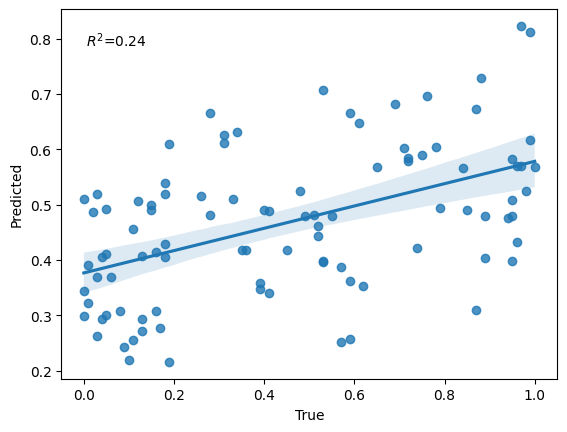

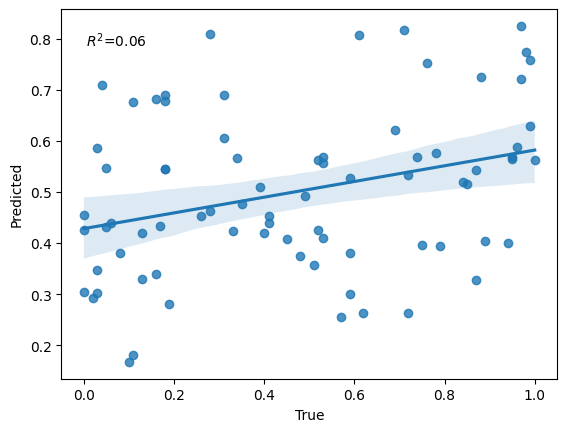

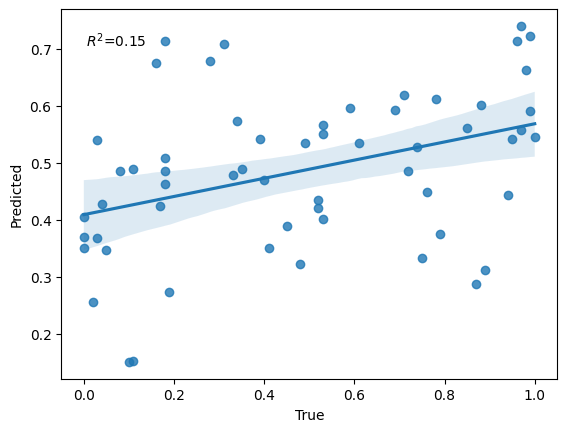

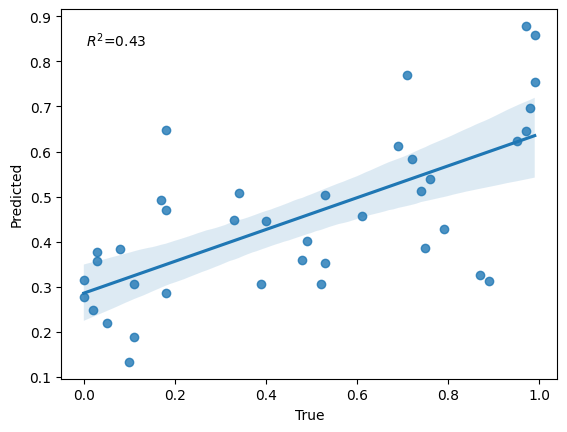

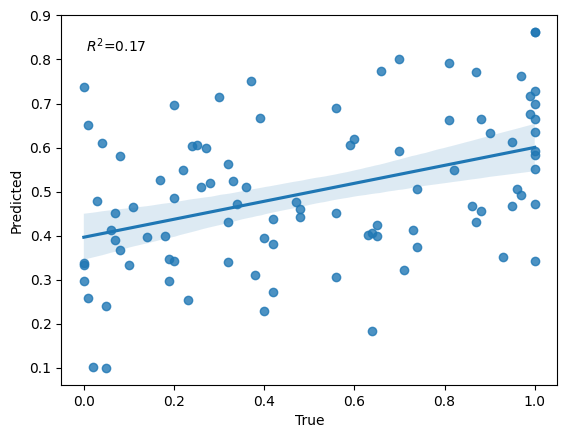

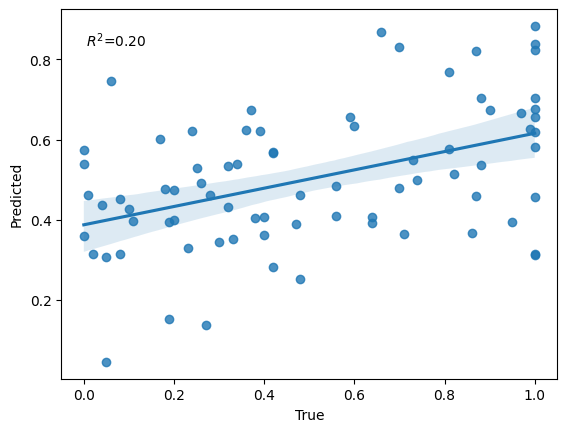

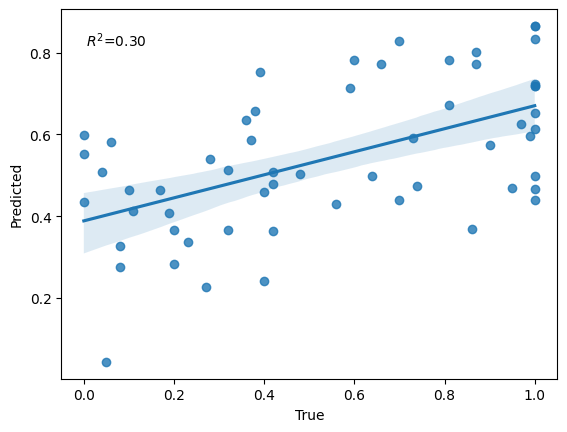

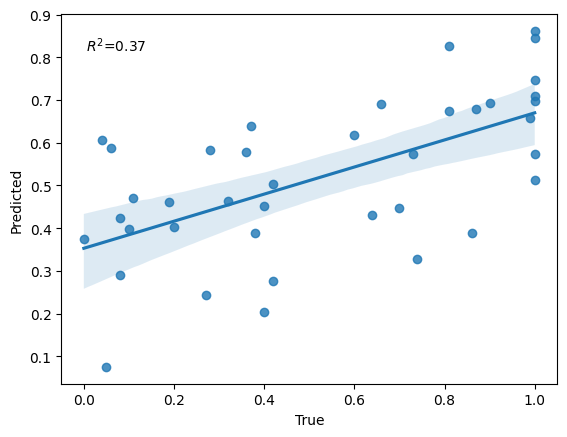

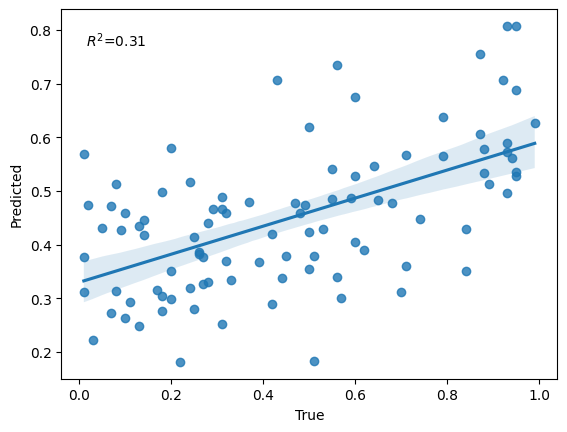

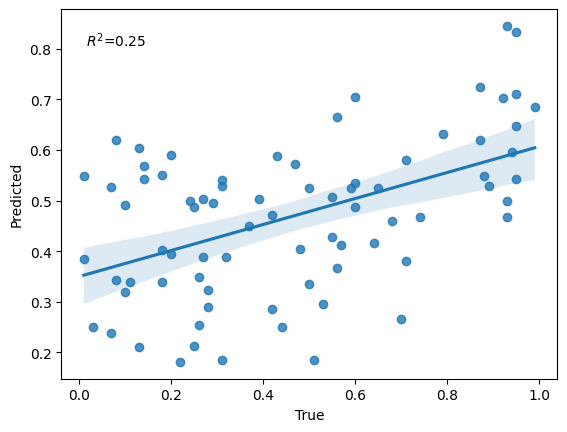

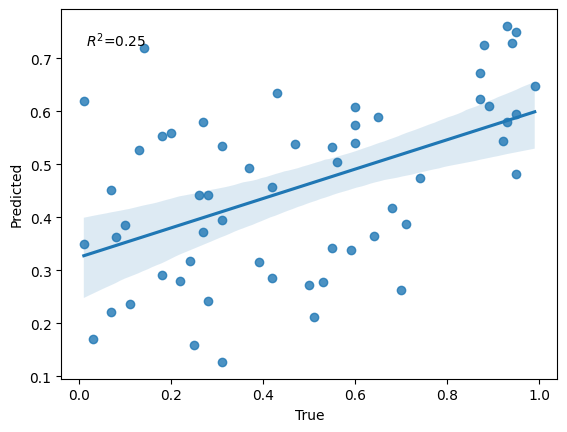

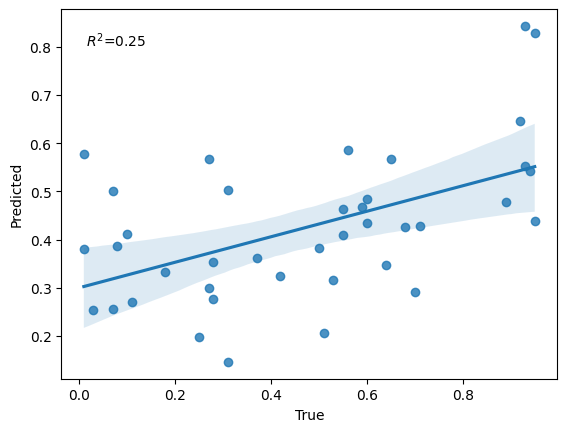

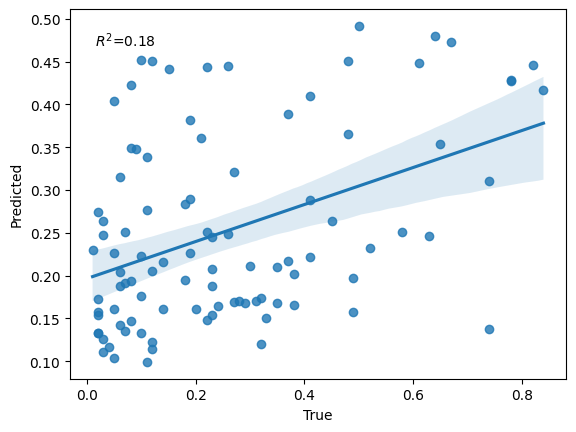

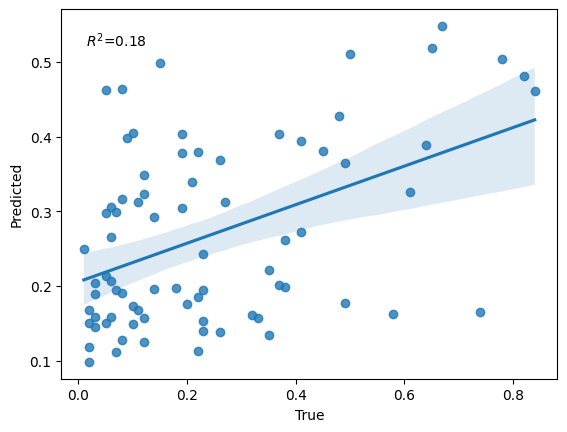

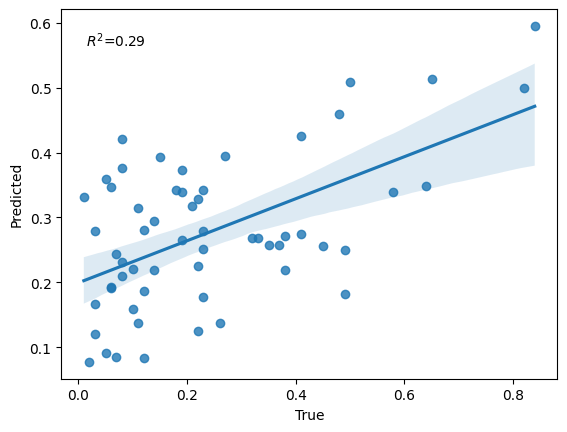

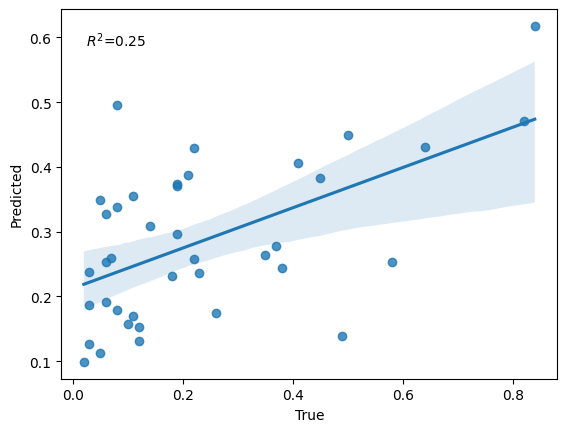

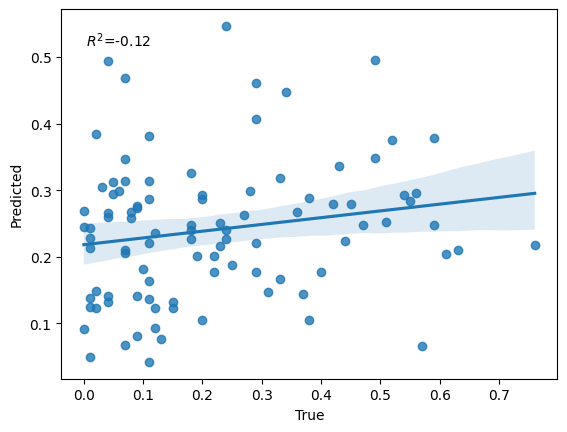

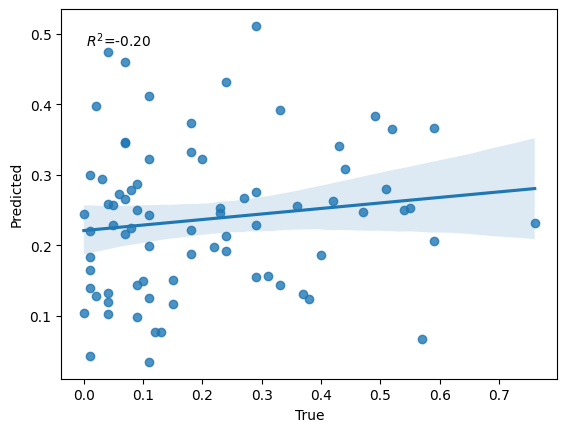

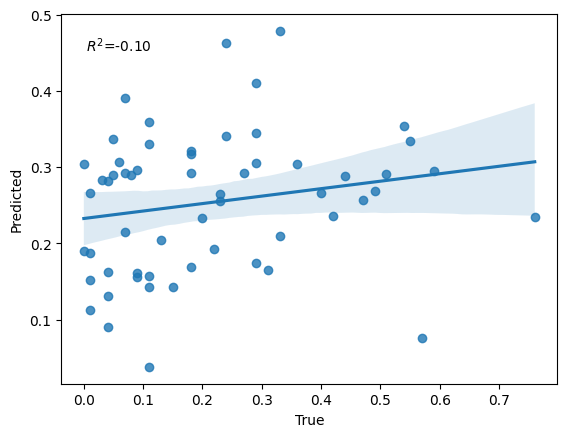

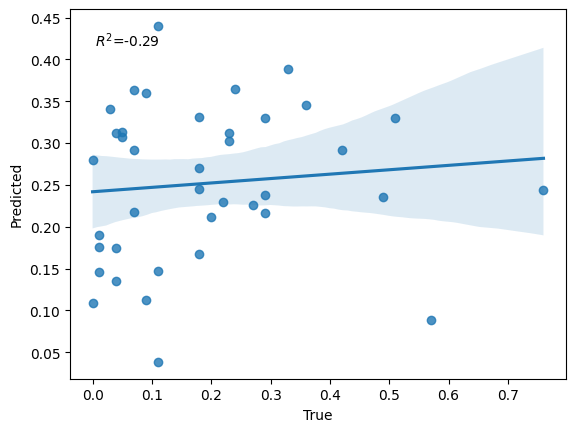

In [ ]:
# generalizing the approach for objective 3 such that we only have to vary the substrate and training size

def classification_and_regression(selected_substrate, training_size):
  print(f'Selected substrate is {selected_substrate} and training size is {training_size}')
  # load data for selected substrate and split for training and testing
  subset_data = classification_df.loc[classification_df[substrate_names_column] == selected_substrate]
  subset_train, subset_test = train_test_split(subset_data, test_size=1-training_size, random_state=42)
  trained_model_classifier = train_and_validate_classifier(subset_train, target_classification, target_threshold, list_of_training_substrates, test_size, model_classifier, substrate_names_column)
  predict_and_evaluate_performance(subset_test, trained_model_classifier, list_of_test_substrates, substrate_names_column, target_classification)
  show_feature_importance(subset_test, trained_model_classifier, target_classification, substrate_names_column)

  subset_data = regression_df.loc[regression_df[substrate_names_column] == selected_substrate]
  subset_train, subset_test = train_test_split(subset_data, test_size=1-training_size, random_state=42)
  trained_model_regressor = train_and_validate_regressor(subset_train, target_regression, list_of_training_substrates, test_size, model_regressor, substrate_names_column)
  predict_and_evaluate_performance_regressor(subset_test, trained_model_regressor, list_of_test_substrates, substrate_names_column, target_regression, title=None, ax=None)
  show_feature_importance(subset_test, trained_model_regressor, target_regression, substrate_names_column)

# list_of_training_substrates = ['SM3', 'SM8', 'SM7']
# subset_size = 0.7  # use % of subset_substrate for training and the rest to test the model
# subset_substrate = 'SM7'
# classification_and_regression(list_of_training_substrates, subset_size, subset_substrate)
possible_substrates = ['SM1', 'SM2', 'SM3', 'SM7', 'SM8']

for selected_substrate in possible_substrates:
  for training_size in np.arange(0.5, 0.9, 0.1):
    classification_and_regression(selected_substrate, training_size)

### Leave-one-out approach

In [ ]:
all_substrates = ['SM1', 'SM2', 'SM3', 'SM4', 'SM5', 'SM6', 'SM7', 'SM8']

for test_substrate in all_substrates:
  print(f'Test substrate is {test_substrate}')
  # use all substrates except the test substrate for training
  list_of_training_substrates = [substrate for substrate in all_substrates if substrate != test_substrate]
  model = RandomForestClassifier(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=13, n_estimators=100, random_state=42)
  # model = TPOTClassifier(generations=5, population_size=20, cv=5, n_jobs=-1, verbosity=2, random_state=42)
  trained_model = train_and_validate_classifier(final_df, target, target_threshold, list_of_training_substrates, test_size, model, substrate_names_column)

  list_of_test_substrates = [test_substrate]
  predict_and_evaluate_performance(final_df, trained_model, list_of_test_substrates, substrate_names_column)
  # show_feature_importance(final_df, trained_model, target, substrate_names_column)

NameError: ignored